# Preparatory
Import packages, setting configuration parameters and write an intergrated class for data pre-processing and reading.

In [1]:
!pip install rouge
!pip install gensim

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [431]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import os
import json
import gensim
import pickle as pkl
import collections
import random
from rouge import Rouge 
from sklearn import metrics
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [81]:
os.getcwd()

'/home/featurize'

**Configuration setting**

In [523]:
config ={}
config['global'] = {} # global parameters
config['embedding'] = {} # embedding layer parameters
config['sent_encoder'] = {} # sentence encoder layer parameters
config['doc_encoder'] = {} # document encoder parameters
config['doc_decoder'] = {} # document decoder parameters
config['embedding']['word2vec'] = {'embedding_dim':128, # embedding dimension
                                   'vocab_size':30000} #vocab_size
config['global']['batch_size']=32 # batch size
config['global']['doc_length']=70 # document length
config['global']['sent_length']=100 # sentence length
config['sent_encoder']['CNN'] = {'num_filters':100, # number of filters
                                 'l2_regulation':3, # l2 regulation parameter
                                 'dropout':0.5} # dropout parameter
config['sent_encoder']['RNN'] = {'hidden_dim':128} # hidden dimension for RNN document encoder
config['doc_encoder']['BiLSTM'] = {'hidden_dim':512} # BiLSTM sentence encoder hidden dimension

# We call Information Interactive Layer "Score layer" in our code.
config['doc_decoder']['Scoring_Layer'] = {'hidden_units':100, # Scoring layer hidden units
                                    'pos_embedding_dim':64, # position embedding dimension
                                    'segment_nums':10, #  relative position segmentation number
                                    'segment_len':7.0,} # relative position segementation length
textfile_merged = open('config.json','w')
json.dump(config, textfile_merged,indent=2)
textfile_merged.close()

**Data loader**

In [524]:
class batch_reader:
  def __init__(self,input_dir):
    textfile_merged = open('config.json', 'rb')
    configs = json.load(textfile_merged)
    textfile_merged.close()
    doc_length = configs['global']['doc_length']
    BATCH_SIZE = configs['global']['batch_size']
    sent_length = configs['global']['sent_length']
    self.tokenizer=0 # Tokenizer, 0 if there is no tokenizer now
    self.sample_per_file=16 # 16 articles per file
    self.BATCH_SIZE=int(BATCH_SIZE/self.sample_per_file) # number of files per batch
    self.dir=input_dir
    self.l=len(os.listdir(self.dir)) # number of files
    self.nums=int(self.l/self.BATCH_SIZE)-1 # number of batches
    self.index=0 # current index of file
    self.sent_length=sent_length 
    self.doc_length=doc_length
    self.file_order=[i for i in range(self.nums)] # file order

  def iter(self):
    # Change the index to the one belonging to next batch
    self.index=(self.index+1) % self.nums
  def shuffle(self):
    random.shuffle(self.file_order)
  def return_to_normal(self):
    self.file_order=[i for i in range(self.nums)]
  def pad_word(self,sent):
    # Padding the sentence to the length of max words=100
    if len(sent)>self.sent_length:
      sent=sent[:self.sent_length]
    else:
      sent += ['<pad>'] * (self.sent_length - len(sent))
    return sent
  def pad_sent(self,document):
    # Padding the document to the length of max sentences=70
    if len(document)>self.doc_length:
      document=document[:self.doc_length]
    else:
      document +=[['<pad>']*self.sent_length] * (self.doc_length - len(document))
    return document
  def map_to_one_hot(self,labels):
    # One hot mapping
    list_init=[0]*self.doc_length
    for i in labels:
      if i<=self.doc_length-1:
        list_init[i]=1
    return list_init
  def next_batch(self,output_type='words'):
    # Files belong to the batch
    self.f_list=[str(j+self.file_order[self.index]*self.BATCH_SIZE)+'.json' for j in range(self.BATCH_SIZE)]
    if output_type=='words':
      # Split sentences into words, to be directly embedded in Word2Vec
      documents=[]
      summary_labels=[]
      for f in self.f_list:
        with open(self.dir+f, "rb") as infile:
          file_json=json.load(infile)
          for index in range(self.sample_per_file):
            json_now=file_json[str(index)]
            splitted=[self.pad_word(sent.split()) for sent in json_now['article']]
            documents.append(self.pad_sent(splitted))
            summary_labels.append(self.map_to_one_hot(json_now['label']))
    elif output_type=="sents":
      # Raw sentence, might be used in BERT
      documents=[]
      summary_labels=[]
      for f in self.f_list:
        with open(self.dir+f, "rb") as infile:
          file_json=json.load(infile)
          for index in range(self.sample_per_file):
            json_now=file_json[str(index)]
            splitted=[sent for sent in json_now['article']]
            documents.append(self.pad_sent(splitted))
            summary_labels.append(self.map_to_one_hot(json_now['label']))
    # next batch of files
    self.iter()
    if self.tokenizer==0: # if there is no tokenizer
      return np.array(documents),np.array(summary_labels)
    else: # if there is a tokenizer
      # return tokens
      return self.tokenizer(np.array(documents)),np.array(summary_labels)
  def insert_tokenizer(self,tokenizer):
    # insert a tokenizer
    self.tokenizer=tokenizer
  def generator(self):
    # generator for building tensorflow dataset
    while True:
        yield self.next_batch()

# Embedding layer
Detailed in the report, we use embedding dimension 128 and vocabulary size 30000 according to our experimental tries.

In [525]:
class Embedding_preparation:
  def __init__(self,path='/data/Dataset_Batch/vocab_cnt.pkl'):
    textfile_merged = open('config.json', 'rb')
    configs = json.load(textfile_merged)
    textfile_merged.close()
    embedding_dim = configs['embedding']['word2vec']['embedding_dim']
    vocab_size = configs['embedding']['word2vec']['vocab_size']
    self.path=os.getcwd()+path
    self.vocab_size=vocab_size # vocabulary size
    self.embedding_dim=embedding_dim # embedding_dimension
    with open(self.path,'rb' ) as f:
      # A file in the dataset, counting the appearance of words in dataset
      self.count_dict = pkl.load(f)
    self.PAD = 0
    self.UNK = 1
    self.START = 2
    self.END = 3
    self.word2id = self.make_vocab() # word to token vocabulary
    # A dictionary which would output unknown token for unknown words
    self.robust_word2id= collections.defaultdict(lambda: self.UNK, self.word2id) 
    # index to word vocabulary
    self.id2word={id: word for word, id in self.word2id.items()}
    # word to vector embedding from pretrained
    self.word2vec=gensim.models.Word2Vec.load(os.getcwd()+'/data/Dataset_Batch/word2vec/word2vec.128d.226k.bin').wv
    self.embedding_matrix=np.zeros((self.vocab_size, self.embedding_dim))
    for word,id in self.word2id.items():
      if id<=1: # Case for <unk> and <pad>
        # Random embedding for these two signals
        self.embedding_matrix[id]=np.random.rand(128)*2-1
      elif id==2: # Case for <START>
        self.embedding_matrix[id]=self.word2vec['<s>']
      elif id==3: # Case for <END>
        self.embedding_matrix[id]=self.word2vec[r'<\s>']
      else: # Case for other words
        self.embedding_matrix[id]=self.word2vec[word]
    # pre-trained embedding
    self.embedding_layer = layers.Embedding(vocab_size,embedding_dim,
        embeddings_initializer=keras.initializers.Constant(self.embedding_matrix),
        trainable=False,
    )
    # pre-trained embedding which can be fine tuned 
    self.embedding_layer_fine_tune = layers.Embedding(vocab_size,embedding_dim,
        embeddings_initializer=keras.initializers.Constant(self.embedding_matrix),
        trainable=True,
    )
  def tokenize(self,wordlist,):
    # tokenize a list of words
    return [self.robust_word2id[word] for word in wordlist]
  def make_vocab(self):
    word2id = {}
    word2id['<pad>'] = self.PAD
    word2id['<unk>'] = self.UNK
    word2id['<start>'] = self.START
    word2id['<end>'] = self.END
    # Find (top vocab_size-4)-th frequent words and take them into dictionary 
    for index, (word, freq) in enumerate(self.count_dict.most_common(self.vocab_size-4), self.END+1):
        word2id[word] = index
    return word2id

# Sentence encoder layer
Sentence encoder encodes the word embedding into sentence embedding. The input shape is (batch_size, doc_size, sent_size, word_embed) and the output shape is (batch_size, doc_size, sent_embed)

## CNN sentence encoder

In [526]:
class CNN_word_extract(keras.layers.Layer):
  def __init__(self):
    textfile_merged = open('config.json', 'rb')
    configs = json.load(textfile_merged)
    textfile_merged.close()
    doc_length=configs['global']['doc_length']
    sent_length=configs['global']['sent_length']
    num_filters=configs['sent_encoder']['CNN']['num_filters']
    regularizer=configs['sent_encoder']['CNN']['l2_regulation']
    dropout_rate=configs['sent_encoder']['CNN']['dropout']
    embedding_dim=config['embedding']['word2vec']['embedding_dim']
    super(CNN_word_extract, self).__init__()
    self.reshaped_shape=(doc_length,sent_length,embedding_dim, 1)
    self.reshape_2 = layers.Reshape(self.reshaped_shape)
    # Three CNN with different kernel size
    self.conv_0_2 = layers.Conv2D(num_filters, kernel_size=(3, embedding_dim),
                                  input_shape=self.reshaped_shape[1:], activation='relu',
                                  kernel_regularizer=keras.regularizers.l2(regularizer))
    self.conv_1_2 = layers.Conv2D(num_filters, kernel_size=(4, embedding_dim),
                                  input_shape=self.reshaped_shape[1:], activation='relu',
                                  kernel_regularizer=keras.regularizers.l2(regularizer))
    self.conv_2_2 = layers.Conv2D(num_filters, kernel_size=(5, embedding_dim),
                                  input_shape=self.reshaped_shape[1:], activation='relu',
                                  kernel_regularizer=keras.regularizers.l2(regularizer))
    # Maxpooling, use MaxPool3D for having a extra dimension
    self.maxpool_0_2 = layers.MaxPool3D(pool_size=(1,sent_length-2,1), strides=(1,1,1), padding='valid')
    self.maxpool_1_2 = layers.MaxPool3D(pool_size=(1,sent_length-3,1), strides=(1,1,1), padding='valid')
    self.maxpool_2_2 = layers.MaxPool3D(pool_size=(1,sent_length-4,1), strides=(1,1,1), padding='valid')
    self.concatenated_tensor_2 = layers.Concatenate(axis=2)
    self.reshape_3 = layers.Reshape((doc_length,3*num_filters))
    self.dropout_2 = layers.Dropout(dropout_rate)
  def call(self,input):
    reshaped=self.reshape_2(input)
    conv_0 = self.conv_0_2(reshaped)
    conv_1 = self.conv_1_2(reshaped)
    conv_2 = self.conv_2_2(reshaped)
    conv_0 = self.maxpool_0_2(conv_0)
    conv_1 = self.maxpool_1_2(conv_1)
    conv_2 = self.maxpool_2_2(conv_2)
    x=self.concatenated_tensor_2([conv_0,conv_1,conv_2])
    x=self.reshape_3(x)
    x=self.dropout_2(x)
    return x

## RNN-based sentence encoder
Here we use **Bidirectional GRU**

In [527]:
class RNN_word_extract(keras.layers.Layer):
    def __init__(self):
        super(RNN_word_extract, self).__init__()
        textfile_merged = open('config.json', 'rb')
        configs = json.load(textfile_merged)
        textfile_merged.close()
        self.hidden_dim=config['sent_encoder']['RNN']['hidden_dim']
        # Bidirectional GRU
        self.layer_1=tf.keras.layers.TimeDistributed(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.hidden_dim, return_sequences=True)))
    
    def call(self,input):
        x=self.layer_1(input)
        # Average pooling over a dimension
        return tf.reduce_mean(x, axis=2)

# Document encoder layer

Document encoder encapsulates the representation within the document. The input shape is (batch_size, doc_size, sent_representation) and the output is (batch_size, doc_size, doc_representation).

## RNN-based document encoder
Here we use **Bidirectional LSTM**

In [536]:
class LSTM_sentence_encoder(keras.layers.Layer):
  def __init__(self,Bidirection=True):
    textfile_merged = open('config.json', 'rb')
    configs = json.load(textfile_merged)
    textfile_merged.close()
    bi_hidden_dim=configs['doc_encoder']['BiLSTM']['hidden_dim']
    super(LSTM_sentence_encoder, self).__init__()
    # Bidirection LSTM
    if Bidirection==True:
      self.lstm=layers.Bidirectional(layers.LSTM(bi_hidden_dim, return_sequences=True,
                                                  kernel_initializer='glorot_uniform'))
  def call(self,input):
    return self.lstm(input)

## Transformer document encoder

In [529]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  d0 = angle_rads.shape[0]
  d1 = angle_rads.shape[1]
  pos_encoding = tf.broadcast_to(angle_rads, (32,d0, d1))

  return tf.cast(pos_encoding, dtype=tf.float32)

def get_mask(seq_k, seq_q):
    ''' For masking out the padding part of key sequence. '''

    # Expand to fit the shape of key query attention matrix.
    seq_k = tf.reduce_sum(seq_k, axis=2)
    seq_q = tf.reduce_sum(seq_q, axis=2)
    len_q = seq_q.shape[1]
    k1 = seq_k.shape[0]
    k2 = seq_k.shape[1]
    padding_mask = tf.cast(tf.math.equal(seq_k, 0), tf.float32)
    padding_mask = tf.broadcast_to(padding_mask[:,np.newaxis, np.newaxis,:], (k1,4, len_q, k2))
    return padding_mask

def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    mask_matrix = mask(q,k)

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask_matrix)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)


    return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [530]:
class transformer_enc(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_encoding = positional_encoding(70, self.d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask=None):

    seq_len = tf.shape(x)[1]

    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x 

# Document decoder layer

This layer decodes the input from document encoder.  The input shape is (batch_size, doc_size, doc_representation) and the output is (batch_size, doc_size). This should output a probability for each sentence.

## Information interactive decoder

In [531]:
class IID_Layer(keras.layers.Layer):
  def __init__(self):
    super(IID_Layer, self).__init__()
    textfile_merged = open('config.json', 'rb')
    configs = json.load(textfile_merged)
    textfile_merged.close()
    self.units = config['doc_decoder']['Scoring_Layer']['hidden_units'] 
    self.batch_size = config['global']['batch_size']
    self.pos_embed_dim = config['doc_decoder']['Scoring_Layer']['pos_embedding_dim'] 
    self.doc_len = configs['global']['doc_length']
    self.segment_nums = config['doc_decoder']['Scoring_Layer']['segment_nums'] 
    self.segment_len = config['doc_decoder']['Scoring_Layer']['segment_len']    # dtype=float32
    # Position embedding
    self.abs_pos_embed = tf.keras.layers.Embedding(self.doc_len, self.pos_embed_dim, name="Abs_Pos_Embed")
    self.rel_pos_embed = tf.keras.layers.Embedding(self.segment_nums, self.pos_embed_dim, name="Rel_Pos_Embed")
    # Dense Layer
    self.dense_1 = tf.keras.layers.Dense(self.units, activation='tanh')
    self.dense_2 = tf.keras.layers.Dense(self.units, activation='relu')
    # Clarify Variables
    self.Wc = self.add_weight(shape=(self.units, 1), initializer="random_normal", trainable=True,name='Wc')
    self.Ws = self.add_weight(shape=(self.units, self.units), initializer="random_normal", trainable=True,name='Ws')
    self.Wr = self.add_weight(shape=(self.units, self.units), initializer="random_normal", trainable=True,name='Wr')
    self.Wap = self.add_weight(shape=(self.pos_embed_dim, 1), initializer="random_normal", trainable=True,name='Wap')
    self.Wrp = self.add_weight(shape=(self.pos_embed_dim, 1), initializer="random_normal", trainable=True,name='Wrp')
    self.bias = self.add_weight(shape=(self.batch_size, 1), initializer="random_normal", trainable=True,name='bias')

  def call(self, inputs):
    # Average pooling
    self.avg_pool = tf.reduce_mean(inputs, axis=1)  #(batch_size,400)
    # Dense Layer(Non-linear transformation)
    self.d = self.dense_1(self.avg_pool)  #(batch_size, 100)
    # Score layer
    self.valid_hiddens = tf.keras.layers.TimeDistributed(self.dense_2)(inputs) #(batch_size, 70, 100)
    for position, sent_hidden in enumerate(tf.unstack(self.valid_hiddens, axis = 1)):
      # Content, Salience, Novelty
      content = tf.matmul(sent_hidden, self.Wc)  #(batch_size, 1)
      salience = tf.math.reduce_sum(tf.math.multiply(tf.matmul(sent_hidden, self.Ws), self.d), axis=1)
      salience = tf.reshape(salience, (-1, 1))  #(batch_size, 1)
      if position == 0:
        novelty = tf.zeros([self.batch_size, 1])  #(batch_size, 1)
      else:
        novelty = -1 * tf.math.reduce_sum(tf.math.multiply(tf.matmul(sent_hidden, self.Wr), tf.math.tanh(self.s)), axis=1)
        novelty = tf.reshape(novelty, (-1, 1))  #(batch_size, 1)
      # abs_pos, rel_pos
      batch_layer = tf.ones([self.batch_size, self.pos_embed_dim])   #(batch_size, pos_embed_dim)
      abs_features = tf.math.multiply(batch_layer, self.abs_pos_embed(tf.constant([position])))  #(batch_size, pos_embed_dim)
      rel_index = int(round((position + 1) * self.segment_len / self.doc_len))
      rel_features = tf.math.multiply(batch_layer, self.rel_pos_embed(tf.constant([rel_index])))  #(batch_size, pos_embed_dim)
      abs_pos = tf.matmul(abs_features, self.Wap)  #(batch_size, 1)
      rel_pos = tf.matmul(rel_features, self.Wrp)  #(batch_size, 1)
      Prob = tf.math.sigmoid(content + salience + novelty + abs_pos + rel_pos + self.bias)  #(batch_size, 1)
      if position == 0:
        self.s = tf.math.multiply(sent_hidden, Prob)
        self.Probs = Prob
      else:
        self.s += tf.math.multiply(sent_hidden, Prob)
        self.Probs = tf.concat([self.Probs, Prob], axis=1)  #(batch_size, 70)
    return self.Probs

## Tabular linear decoder

In [532]:
class RawMLP_decoder(keras.layers.Layer):
  def __init__(self):
    super(RawMLP_decoder, self).__init__()
    self.mlp=layers.Dense(1,activation='sigmoid')
  def call(self,input):
    return self.mlp(input)[:,:,0]

# Implementation

## Utilisation functions and classes

In [537]:
textfile_merged = open(os.getcwd()+'/config.json', 'rb')
configs = json.load(textfile_merged)
embedding_dim=configs['embedding']['word2vec']['embedding_dim']
batch_size=configs['global']['batch_size']
doc_length=configs['global']['doc_length']
sent_length=configs['global']['sent_length']
train_dir=os.getcwd() + '/data/Dataset_Batch/train/'
Embedding=Embedding_preparation()
batch_iter = batch_reader(train_dir)
batch_iter.insert_tokenizer(np.vectorize(lambda e: Embedding.robust_word2id[e]))
dataset=tf.data.Dataset.from_generator(
    batch_iter.generator, output_types=(tf.int32, tf.int32), output_shapes=((batch_size,doc_length,sent_length),(batch_size,doc_length)))
val_dir=os.getcwd() + '/data/Dataset_Batch/val/'
val_batch_iter = batch_reader(val_dir)
val_batch_iter.insert_tokenizer(np.vectorize(lambda e: Embedding.robust_word2id[e]))
val_dataset=tf.data.Dataset.from_generator(
    val_batch_iter.generator, output_types=(tf.int32, tf.int32), output_shapes=((batch_size,doc_length,sent_length),(batch_size,doc_length)))
# Tokenized document

def dispatch(func_name_dict,name, *args, **kwargs):
  return func_name_dict[name](*args, **kwargs)

def build_model(emb,sent_enc,doc_enc,dec):
  embedding_dict={'word2vec':Embedding.embedding_layer,
                  'word2vec_fine_tune':Embedding.embedding_layer_fine_tune}
  sent_encoder_dict={'CNN':CNN_word_extract(),
                  'RNN':RNN_word_extract()}
  doc_encoder_dict={'BiLSTM':LSTM_sentence_encoder(Bidirection=True),
                  "transformer": transformer_enc(num_layers=4, d_model=256, num_heads=4,
                         dff=1024, input_vocab_size=30000)}
  decoder_dict={'RawMLP':RawMLP_decoder(),
                'IID_Layer':IID_Layer()}
  inputs=keras.Input(batch_shape=(batch_size,doc_length,sent_length),name='Input')
  embedded=dispatch(embedding_dict,emb,inputs)
  word_2_sent=dispatch(sent_encoder_dict,sent_enc,embedded)
  if doc_enc == "transformer":
    doc_encoder=dispatch(doc_encoder_dict,doc_enc,word_2_sent, True, get_mask)
  else:
    doc_encoder=dispatch(doc_encoder_dict,doc_enc,word_2_sent)
  doc_decoder=dispatch(decoder_dict,dec,doc_encoder)
  output=doc_decoder
  return keras.Model(inputs=inputs, outputs=output)

In [726]:
def read_model(emb, se, de, dc):
    model = build_model(emb, se, de, dc)
    filepath = os.getcwd()+'/'+emb+'_'+se+'_'+de+'_'+dc+'/'
    f = open(filepath+'loss.json')
    loss = json.load(f)
    best_epoch = np.argmin(np.array(loss["val_loss"]))+1
    best_epoch = '0'+str(best_epoch) if best_epoch<10 else str(best_epoch)
    model.load_weights(filepath+'model_1-'+best_epoch)
    return model

class Util(object):
    def __init__(self, model, lead=False):
        self.model = model
        self.lead = lead
    
    def computing_summaries(self, pred_vector):
        generated_summaries=[]
        true_summaries=[]
        for i,f in enumerate(self.batch_iter.f_list):
            with open(self.batch_iter.dir+f, "rb") as infile:
                file_json=json.load(infile)
                for index in range(self.batch_iter.sample_per_file):
                    json_now=file_json[str(index)]
                    generated_summaries.append(" ".join([sent if pred_vector[i*self.batch_iter.sample_per_file+index][min(j,config['global']['doc_length']-1)]==1 else '' for j,sent in enumerate(json_now['article'])]))
                    true_summaries.append(" ".join(json_now['abstract']))
        return generated_summaries,true_summaries
    
    def rouge_onebatch(self, N_gram, metric, generated_summaries,true_summaries):
        rouge = Rouge()
        l=len(generated_summaries)
        avg=0.
        for i in range(l):
            if len(generated_summaries[i])==0: #to prevent empty hypothesis
                score = 0
            else:
                score = rouge.get_scores(generated_summaries[i],true_summaries[i])[0][N_gram][metric]
            avg += score
        avg = avg / l
        return avg
    
    def rouge_overall(self, batch_iter, N_gram, metric, threshold):
        self.batch_iter = batch_iter
        self.batch_iter.insert_tokenizer(np.vectorize(lambda e: prep.robust_word2id[e]))
        i=0
        rouge_all=[]
        while i<self.batch_iter.nums:
            doc,label=self.batch_iter.next_batch()
            if self.lead:
                vec = np.array([[1 if i<3 else 0 for i in range(70)] for i in range(config['global']['batch_size'])])
            else:
                vec = np.vectorize(lambda x: 1 if x >= threshold else 0)(self.model.predict(doc))
                
            generated_summaries,true_summaries=self.computing_summaries(vec)
            rouge_all.append(self.rouge_onebatch(N_gram, metric,generated_summaries,true_summaries))
            i+=1
        return np.mean(rouge_all)
    
    def roc_curve(self, batch_iter):
        batch_iter.insert_tokenizer(np.vectorize(lambda e: prep.robust_word2id[e]))
        i=0
        label_total = []
        pred_total = []
        while i<batch_iter.nums:
            doc,label=batch_iter.next_batch()
            pred = self.model.predict(doc)
            
            ind_sent = np.sum(doc, axis=2)!=0 #the index of non-trivial sentences.
            label_total += list(label[ind_sent])
            pred_total += list(pred[ind_sent])
            
            i+=1
        label_new = np.array(label_total)
        pred_new = np.array(pred_total)
        fpr, tpr,_ = metrics.roc_curve(label_new, pred_new, pos_label=1)
        auc = metrics.roc_auc_score(label_new, pred_new)
        return fpr, tpr, auc

## Model building and training
**IID** means Information Interactive Decoder

**word2vec_CNN_BiLSTM_MLP**

'word2vec','CNN',"BiLSTM",'RawMLP' Around 30 min per epoch

In [24]:
# CNN one
checkpoint_filepath = os.getcwd()+'/word2vec_CNN_BiLSTM_RawMLP/model_1-{epoch:02d}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq=batch_iter.nums,verbose=1)
model= build_model('word2vec','CNN',"BiLSTM",'RawMLP')
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model.fit(dataset,steps_per_epoch=batch_iter.nums,epochs=10,batch_size=1,validation_data=val_dataset,validation_steps=val_batch_iter.nums,callbacks=[model_checkpoint_callback])
textfile_merged = open(os.getcwd()+'/word2vec_CNN_BiLSTM_RawMLP/loss.json','w')
json.dump(model.history.history, textfile_merged,indent=2)
textfile_merged.close()

Epoch 1/10
8974/8975 [============================>.] - ETA: 0s - loss: 0.1884- ETA: 3s -
Epoch 00001: saving model to /home/featurize/word2vec_CNN_BiLSTM_RawMLP/model_1-01
8975/8975 [==============================] - 2115s 235ms/step - loss: 0.1884 - val_loss: 0.1269
Epoch 2/10
8974/8975 [============================>.] - ETA: 0s - loss: 0.1229
Epoch 00002: saving model to /home/featurize/word2vec_CNN_BiLSTM_RawMLP/model_1-02
8975/8975 [==============================] - 2152s 240ms/step - loss: 0.1229 - val_loss: 0.1265
Epoch 3/10
8974/8975 [============================>.] - ETA: 0s - loss: 0.1226
Epoch 00003: saving model to /home/featurize/word2vec_CNN_BiLSTM_RawMLP/model_1-03
8975/8975 [==============================] - 2122s 236ms/step - loss: 0.1226 - val_loss: 0.1262
Epoch 4/10
8974/8975 [============================>.] - ETA: 0s - loss: 0.1218
Epoch 00004: saving model to /home/featurize/word2vec_CNN_BiLSTM_RawMLP/model_1-04
8975/8975 [==============================] - 2206s 24

**word2vec_BiGRU_BiLSTM_MLP**

In [25]:
# w2v rnn rnn mlp
checkpoint_filepath = os.getcwd()+'/word2vec_RNN_BiLSTM_RawMLP/model_1-{epoch:02d}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq=batch_iter.nums,verbose=1)
model= build_model('word2vec','RNN',"BiLSTM",'RawMLP')


In [26]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(32, 70, 100)]           0         
                                                                 
 embedding_1 (Embedding)     (32, 70, 100, 128)        3840000   
                                                                 
 rnn_word_extract_5 (RNN_wor  (32, 70, 256)            198144    
 d_extract)                                                      
                                                                 
 lstm_sentence_encoder_10 (L  (32, 70, 1024)           3149824   
 STM_sentence_encoder)                                           
                                                                 
 raw_mlp_decoder_5 (RawMLP_d  (32, 70)                 1025      
 ecoder)                                                         
                                                           

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model.fit(dataset,steps_per_epoch=batch_iter.nums,epochs=20,batch_size=1,validation_data=val_dataset,validation_steps=val_batch_iter.nums,callbacks=[model_checkpoint_callback])
textfile_merged = open(os.getcwd()+'/word2vec_RNN_BiLSTM_RawMLP/loss.json','w')
json.dump(model.history.history, textfile_merged,indent=2)
textfile_merged.close()

Epoch 1/20
8974/8975 [============================>.] - ETA: 0s - loss: 0.1156
Epoch 00001: saving model to /home/featurize/word2vec_RNN_RNN_RawMLP/model_1-01
8975/8975 [==============================] - 2192s 244ms/step - loss: 0.1156 - val_loss: 0.1175
Epoch 2/20
8974/8975 [============================>.] - ETA: 0s - loss: 0.1123
Epoch 00002: saving model to /home/featurize/word2vec_RNN_RNN_RawMLP/model_1-02
8975/8975 [==============================] - 2183s 243ms/step - loss: 0.1123 - val_loss: 0.1163
Epoch 3/20
8974/8975 [============================>.] - ETA: 0s - loss: 0.1114
Epoch 00003: saving model to /home/featurize/word2vec_RNN_RNN_RawMLP/model_1-03
8975/8975 [==============================] - 2164s 241ms/step - loss: 0.1114 - val_loss: 0.1157
Epoch 4/20
5534/8975 [=================>............] - ETA: 12:46 - loss: 0.1055

**word2vec_BiGRU_BiLSTM_IID**

In [36]:
# w2v rnn rnn score
checkpoint_filepath = os.getcwd()+'/word2vec_RNN_BiLSTM_IID_Layer/model_1-{epoch:02d}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq=batch_iter.nums,verbose=1)
model= build_model('word2vec','RNN',"BiLSTM",'IID_Layer')


In [37]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(32, 70, 100)]           0         
                                                                 
 embedding_1 (Embedding)     (32, 70, 100, 128)        3840000   
                                                                 
 rnn_word_extract_8 (RNN_wor  (32, 70, 256)            198144    
 d_extract)                                                      
                                                                 
 lstm_sentence_encoder_16 (L  (32, 70, 1024)           3149824   
 STM_sentence_encoder)                                           
                                                                 
 score__layer_8 (Score_Layer  (32, 70)                 230380    
 )                                                               
                                                           

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model.fit(dataset,steps_per_epoch=batch_iter.nums,epochs=20,batch_size=1,validation_data=val_dataset,validation_steps=val_batch_iter.nums,callbacks=[model_checkpoint_callback])
textfile_merged = open(os.getcwd()+'/word2vec_RNN_BiLSTM_IID_Layer/loss.json','w')
json.dump(model.history.history, textfile_merged,indent=2)
textfile_merged.close()

Epoch 1/20
8974/8975 [============================>.] - ETA: 0s - loss: 0.1144
Epoch 00001: saving model to /home/featurize/word2vec_RNN_RNN_Scoring_Layer/model_1-01
8975/8975 [==============================] - 2129s 235ms/step - loss: 0.1144 - val_loss: 0.1177
Epoch 2/20
8974/8975 [============================>.] - ETA: 0s - loss: 0.1120
Epoch 00002: saving model to /home/featurize/word2vec_RNN_RNN_Scoring_Layer/model_1-02
8975/8975 [==============================] - 2083s 232ms/step - loss: 0.1120 - val_loss: 0.1165
Epoch 3/20
8974/8975 [============================>.] - ETA: 0s - loss: 0.1111
Epoch 00003: saving model to /home/featurize/word2vec_RNN_RNN_Scoring_Layer/model_1-03
8975/8975 [==============================] - 2054s 229ms/step - loss: 0.1111 - val_loss: 0.1158
Epoch 4/20
8974/8975 [============================>.] - ETA: 0s - loss: 0.1105
Epoch 00004: saving model to /home/featurize/word2vec_RNN_RNN_Scoring_Layer/model_1-04
8975/8975 [==============================] - 206

**word2vec_CNN_BiLSTM_IID**

In [ ]:
# w2v cnn rnn score
checkpoint_filepath = os.getcwd()+'/word2vec_CNN_BiLSTM_IID_Layer/model_1-{epoch:02d}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq=batch_iter.nums,verbose=1)
model= build_model('word2vec','CNN',"BiLSTM",'IID_Layer')


In [ ]:
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model.fit(dataset,steps_per_epoch=batch_iter.nums,epochs=20,batch_size=1,validation_data=val_dataset,validation_steps=val_batch_iter.nums,callbacks=[model_checkpoint_callback])
textfile_merged = open(os.getcwd()+'/word2vec_CNN_BiLSTM_IID_Layer/loss.json','w')
json.dump(model.history.history, textfile_merged,indent=2)
textfile_merged.close()

**word2vec_BiGRU_Transformer_IID**

In [49]:
checkpoint_filepath = os.getcwd()+'/word2vec_RNN_transformer_Scoring_Layer/model_1-{epoch:02d}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq=batch_iter.nums,verbose=1)
model= build_model('word2vec','RNN',"transformer",'IID_Layer')

In [50]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(32, 70, 100)]           0         
                                                                 
 embedding_3 (Embedding)     (32, 70, 100, 128)        3840000   
                                                                 
 rnn_word_extract_13 (RNN_wo  (32, 70, 256)            198144    
 rd_extract)                                                     
                                                                 
 transformer_enc_13 (transfo  (32, 70, 256)            3159040   
 rmer_enc)                                                       
                                                                 
 score__layer_12 (Score_Laye  (32, 70)                 76780     
 r)                                                              
                                                          

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model.fit(dataset,steps_per_epoch=batch_iter.nums,epochs=20,batch_size=1,validation_data=val_dataset,validation_steps=val_batch_iter.nums,callbacks=[model_checkpoint_callback])
textfile_merged = open(os.getcwd()+'/word2vec_RNN_transformer_IID_Layer/loss.json','w')
json.dump(model.history.history, textfile_merged,indent=2)
textfile_merged.close()

Epoch 1/20
5203/8975 [================>.............] - ETA: 15:23 - loss: 0.1132

**fine-tune word2vec_BiGRU_Transformer_IID**

In [74]:
checkpoint_filepath = os.getcwd()+'/word2vec_fine_tune_RNN_transformer_IID_Layer/model_1-{epoch:02d}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq=batch_iter.nums,verbose=1)
model= build_model('word2vec_fine_tune','RNN',"transformer",'IID_Layer')
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(32, 70, 100)]           0         
                                                                 
 embedding_6 (Embedding)     (32, 70, 100, 128)        3840000   
                                                                 
 rnn_word_extract_21 (RNN_wo  (32, 70, 256)            198144    
 rd_extract)                                                     
                                                                 
 transformer_enc_21 (transfo  (32, 70, 256)            3159040   
 rmer_enc)                                                       
                                                                 
 score__layer_20 (Score_Laye  (32, 70)                 76780     
 r)                                                              
                                                          

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model.fit(dataset,steps_per_epoch=batch_iter.nums,epochs=20,batch_size=1,validation_data=val_dataset,validation_steps=val_batch_iter.nums,callbacks=[model_checkpoint_callback])
textfile_merged = open(os.getcwd()+'/word2vec_fine_tune_RNN_transformer_IID_Layer/loss.json','w')
json.dump(model.history.history, textfile_merged,indent=2)
textfile_merged.close()

Epoch 1/20
2666/8975 [=======>......................] - ETA: 28:12 - loss: 0.1078

**word2vec_CNN_Transformer_IID**

We trained this model but found nothing surprising so we did not conduct further evaluations on it.

In [64]:
checkpoint_filepath = os.getcwd()+'/word2vec_CNN_transformer_IID_Layer/model_1-{epoch:02d}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq=batch_iter.nums,verbose=1)
model= build_model('word2vec','CNN',"transformer",'IID_Layer')

In [65]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(32, 70, 100)]           0         
                                                                 
 embedding_4 (Embedding)     (32, 70, 100, 128)        3840000   
                                                                 
 cnn_word_extract_18 (CNN_wo  (32, 70, 300)            153900    
 rd_extract)                                                     
                                                                 
 transformer_enc_18 (transfo  (32, 70, 300)            3912496   
 rmer_enc)                                                       
                                                                 
 score__layer_17 (Score_Laye  (32, 70)                 85580     
 r)                                                              
                                                          

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model.fit(dataset,steps_per_epoch=batch_iter.nums,epochs=20,batch_size=1,validation_data=val_dataset,validation_steps=val_batch_iter.nums,callbacks=[model_checkpoint_callback])
textfile_merged = open(os.getcwd()+'/word2vec_CNN_transformer_IID_Layer/loss.json','w')
json.dump(model.history.history, textfile_merged,indent=2)
textfile_merged.close()

Epoch 1/20


**Training/Validation loss plots during training**

In [739]:
def read_loss(em,se, de, dc):
    filepath = os.getcwd()+'/'+em+'_'+se+'_'+de+'_'+dc+'/'
    f = open(filepath+'loss.json')
    loss = json.load(f)
    training_loss = loss["loss"]
    val_loss = loss["val_loss"]
    return training_loss, val_loss

loss_1 = read_loss("word2vec", "CNN","BiLSTM","RawMLP")

loss_2 = read_loss("word2vec", "RNN","BiLSTM","RawMLP")

loss_3 = read_loss("word2vec", "CNN","BiLSTM","IID_Layer")

loss_4 = read_loss("word2vec", "RNN","BiLSTM","IID_Layer")

loss_5 = read_loss("word2vec", "RNN","transformer","IID_Layer")

loss_6 = read_loss("word2vec_fine_tune", "RNN","transformer","IID_Layer")

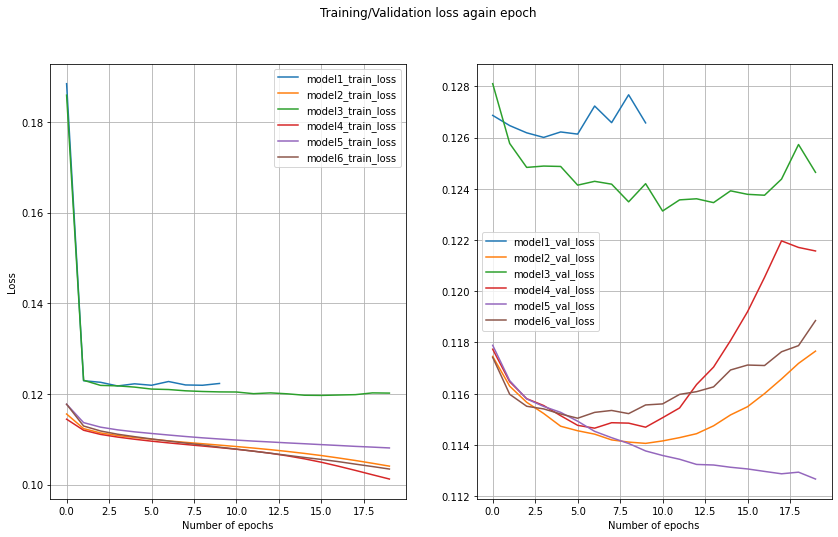

In [762]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(loss_1[0], label="model1_train_loss")
ax[1].plot(loss_1[1], label="model1_val_loss")

ax[0].plot(loss_2[0], label="model2_train_loss")
ax[1].plot(loss_2[1], label="model2_val_loss")

ax[0].plot(loss_3[0], label="model3_train_loss")
ax[1].plot(loss_3[1], label="model3_val_loss")

ax[0].plot(loss_4[0], label="model4_train_loss")
ax[1].plot(loss_4[1], label="model4_val_loss")

ax[0].plot(loss_5[0], label="model5_train_loss")
ax[1].plot(loss_5[1], label="model5_val_loss")

ax[0].plot(loss_6[0], label="model6_train_loss")
ax[1].plot(loss_6[1], label="model6_val_loss")

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel("Number of epochs")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Number of epochs")
plt.suptitle("Training/Validation loss again epoch")
#fig.savefig("Loss.png", bbox_inches='tight')
plt.show()

## Evaluation
**Models built**

In [ ]:
model1 = read_model("word2vec", "CNN","BiLSTM","RawMLP")

model2 = read_model("word2vec", "RNN","BiLSTM","RawMLP")

model3 = read_model("word2vec", "CNN","BiLSTM","Scoring_Layer")

model4 = read_model("word2vec", "RNN","BiLSTM","Scoring_Layer")

model5 = read_model("word2vec", "RNN","transformer","Scoring_Layer")

model6 = read_model("word2vec_fine_tune", "RNN","transformer","Scoring_Layer")

### ROC curve metrics
After eliminating trivial sentences of documents from testing set, we have in total 306280 non-trivial sentences. This gives 306280 labels and probabilities of labelling 1. And for each model we will use this pair to plot the ROC curve and the AUC score.

In [ ]:
models = [model1, model2, model3, model4, model5, model6]
metric_dic = {"model1":None,
          "model2": None,
          "model3": None,
          "model4": None,
          "model5": None,
          "model6": None}

for index, Model in enumerate(models):
    test_dir=os.getcwd() + '/data/Dataset_Batch/test/'
    batch_iter = batch_reader(test_dir)
    obj = Util(Model)
    metric_dic[f"model{index+1}"] = obj.roc_curve(batch_iter)

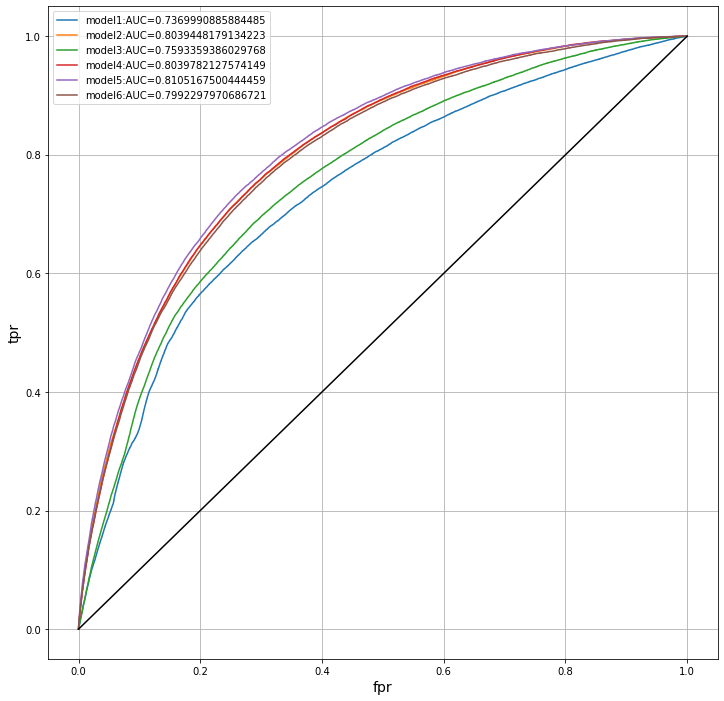

In [582]:
fig, ax = plt.subplots(figsize=(12,12))
for i in range(1,7):
    fpr, tpr, auc = metric_dic[f"model{i}"]
    ax.plot(fpr, tpr, label=f"model{i}:AUC={auc}")
ax.plot([0,1],[0,1],"k")
ax.set_xlabel("fpr", fontsize=14)
ax.set_ylabel("tpr", fontsize=14)
ax.grid()
ax.legend()
#fig.savefig("ROC.png", bbox_inches='tight')
plt.show()

From the perspective of ROC metric, model 1 and model 3 have the lowest
figures. And these two models both use CNN as the sentence encoder, also we can find that the two models
have the highest validation loss during training. The model with the best performance in terms of AUC score
is model 5, which is equipped with word2vec+BiGRU+BiLSTM+Transformer+IID. This model also has the
lowest validation loss.

### ROUGE metrics
In this part we will use ROUGE-1, ROUGE-2 and ROUGE-L(detailed in the report) to evaluate the performance of our models. Each of the  three consists of 3 types of metrics: Recall, Precision and F1 score. Since we are using the full-length variants so that F1 can better reflect the overall performances of models. We will also try 3 different threshold values on classification.

**Imbalance of labels on the training set**

When selecting threshold $P(y>\tau)=1$ on the classification, we need to first assess the imbalance of labels on the training dataset, since it is a relevant measure depending on the data set, so deterministically set $\tau=0.5$ may not be an optimal strategy. Here we calculate the rate of imbalance on the training set: $$Imbalance = \frac{\#Negative~labels}{\#Postive~ labels}=\frac{6860319}{854206}=8.03$$

In [702]:
train_dir=os.getcwd() + '/data/Dataset_Batch/train/'
batch_iter = batch_reader(train_dir)
def imbalance_rate(batch_iter):
    batch_iter.insert_tokenizer(np.vectorize(lambda e: prep.robust_word2id[e]))
    i=0
    label_total = []
    while i<batch_iter.nums:
        doc,label=batch_iter.next_batch()
        ind_sent = np.sum(doc, axis=2)!=0 #the index of non-trivial sentences.
        label_total += list(label[ind_sent])
        i+=1
    label_new = np.array(label_total)
    pos_label = label_new.sum()
    neg_label = label_new.size-pos_label
    return pos_label, neg_label

training_imbalance = imbalance_rate(batch_iter)

In [704]:
print(f"The number of positive training labels:{training_imbalance[0]}")
print(f"The number of negative training labels:{training_imbalance[1]}")

The number of positive training labels:854206
The number of negative training labels:6860319


So it is not surprising that if we set only $\tau=0.5$, we cannot expect sound results from any model. After experiments and to meet the limited computation resource, we set three interpretable threshold values: $\tau=\{0.2,0.3,0.4\}$

**Computing ROUGE for Baseline Lead-3 model**

In [ ]:
#compute the ROUGE-1. ROUGE-2 and ROUGE-L metric for Lead-3 model.
def lead_rouge(N_gram):
    test_dir=os.getcwd() + '/data/Dataset_Batch/test/'
    batch_iter = batch_reader(test_dir)
    obj = Util(model6, lead=True) #the first argument does not matter when lead=True
    lead_score = obj.rouge_overall(batch_iter, N_gram, "f", 0.4) #threshold also does not matter when lead=True
    return lead_score

lead_rouge_1 = lead_rouge("rouge-1")
lead_rouge_2 = lead_rouge("rouge-2")
lead_rouge_L = lead_rouge("rouge-l")

In [729]:
print(f"ROUGE-1 for Lead-3 model:{lead_rouge_1}")
print(f"ROUGE-2 for Lead-3 model:{lead_rouge_2}")
print(f"ROUGE-L for Lead-3 model:{lead_rouge_L}")

ROUGE-1 for Lead-3 model:0.4071
ROUGE-2 for Lead-3 model:0.1705
ROUGE-L for Lead-3 model:0.3707


**Computing ROUGE for other models**

In [646]:
model_map = {"model1":None,
          "model2": None,
          "model3": None,
          "model4": None,
          "model5": None,
          "model6": None}

N_grams = {"rouge-1":model_map,
           "rouge-2":model_map,
           "rouge-l":model_map}

threshold_map = {"0.2":N_grams,
                "0.3":N_grams,
                "0.4":N_grams}

models = [model1, model2, model3, model4, model5, model6]
N_grams_names = ["rouge-1","rouge-2","rouge-l"]
threshold_names = ["0.2","0.3","0.4"]

In [ ]:
for threshold_name in threshold_names:
    threshold = float(threshold_name)
    for N_gram in N_grams_names:
        for index, Model in enumerate(models):
            test_dir=os.getcwd() + '/data/Dataset_Batch/test/'
            batch_iter = batch_reader(test_dir)
            obj = Util(Model)
            value = obj.rouge_overall(batch_iter, N_gram, "f", threshold)
            threshold_map[threshold_name][N_gram][f"model{index+1}"] = value
with open('result.json', 'w') as fp:
    json.dump(threshold_map, fp)

The results from above computation and analysis are shown here, they are also used in the report:

<img src="threshold_0.2.png" />

<img src="threshold_0.3.png" />

<img src="threshold_0.4.png" />

### Generated summaraies from real text

In this part we will use our trained model (Model 6) to summarise from real text documents and compare with true and gold summaries. We will set the threshold $\tau=0.3$.

In [822]:
def get_summaries(batch_iter,vector, gold_vector):
    generated_summaries=[]
    true_summaries=[]
    gold_summaries=[]
    original_doc = []
    for i,f in enumerate(batch_iter.f_list):
        with open(batch_iter.dir+f, "rb") as infile:
            file_json=json.load(infile)
            for index in range(batch_iter.sample_per_file):
                json_now=file_json[str(index)]
                generated_summaries.append(" ".join([sent if vector[i*batch_iter.sample_per_file+index][min(j,config['global']['doc_length']-1)]==1 else '' for j,sent in enumerate(json_now['article'])]))
                gold_summaries.append(" ".join([sent if gold_vector[i*batch_iter.sample_per_file+index][min(j,config['global']['doc_length']-1)]==1 else '' for j,sent in enumerate(json_now['article'])]))
                true_summaries.append(" ".join(json_now['abstract']))
                original_doc.append(" ".join(json_now['article']))
    return generated_summaries,true_summaries, gold_summaries, original_doc

In [893]:
test_dir=os.getcwd() + '/data/Dataset_Batch/test/'
batch_iter = batch_reader(test_dir)
batch_iter.insert_tokenizer(np.vectorize(lambda e: prep.robust_word2id[e]))
doc, label = batch_iter.next_batch()
prediction_vector =  np.vectorize(lambda x: 1 if x >= 0.3 else 0)(model6.predict(doc))
generated_summaries,true_summaries, gold_summaries, original_docs = get_summaries(batch_iter, prediction_vector, label)

**Example 1**

This is also shown as an example in the report

In [883]:
original_docs[5]

"-lrb- cnn -rrb- a duke student has admitted to hanging a noose made of rope from a tree near a student union , university officials said thursday . the prestigious private school did n't identify the student , citing federal privacy laws . in a news release , it said the student was no longer on campus and will face student conduct review . the student was identified during an investigation by campus police and the office of student affairs and admitted to placing the noose on the tree early wednesday , the university said . officials are still trying to determine if other people were involved . criminal investigations into the incident are ongoing as well . students and faculty members marched wednesday afternoon chanting `` we are not afraid . we stand together , '' after pictures of the noose were passed around on social media . at a forum held on the steps of duke chapel , close to where the noose was discovered at 2 a.m. , hundreds of people gathered . `` you came here for the re

In [884]:
generated_summaries[5]

"-lrb- cnn -rrb- a duke student has admitted to hanging a noose made of rope from a tree near a student union , university officials said thursday . the prestigious private school did n't identify the student , citing federal privacy laws . in a news release , it said the student was no longer on campus and will face student conduct review .              "

In [885]:
true_summaries[5]

'student is no longer on duke university campus and will face disciplinary review . school officials identified student during investigation and the person admitted to hanging the noose , duke says . the noose , made of rope , was discovered on campus about 2 a.m.'

In [886]:
gold_summaries[5]

"-lrb- cnn -rrb- a duke student has admitted to hanging a noose made of rope from a tree near a student union , university officials said thursday . the prestigious private school did n't identify the student , citing federal privacy laws . in a news release , it said the student was no longer on campus and will face student conduct review . the student was identified during an investigation by campus police and the office of student affairs and admitted to placing the noose on the tree early wednesday , the university said .             "

**Example 2**

In [875]:
original_docs[1]

"-lrb- cnn -rrb- the palestinian authority officially became the 123rd member of the international criminal court on wednesday , a step that gives the court jurisdiction over alleged crimes in palestinian territories . the formal accession was marked with a ceremony at the hague , in the netherlands , where the court is based . the palestinians signed the icc 's founding rome statute in january , when they also accepted its jurisdiction over alleged crimes committed `` in the occupied palestinian territory , including east jerusalem , since june 13 , 2014 . '' later that month , the icc opened a preliminary examination into the situation in palestinian territories , paving the way for possible war crimes investigations against israelis . as members of the court , palestinians may be subject to counter-charges as well . israel and the united states , neither of which is an icc member , opposed the palestinians ' efforts to join the body . but palestinian foreign minister riad al-malki ,

In [876]:
generated_summaries[1]

"-lrb- cnn -rrb- the palestinian authority officially became the 123rd member of the international criminal court on wednesday , a step that gives the court jurisdiction over alleged crimes in palestinian territories . the formal accession was marked with a ceremony at the hague , in the netherlands , where the court is based . the palestinians signed the icc 's founding rome statute in january , when they also accepted its jurisdiction over alleged crimes committed `` in the occupied palestinian territory , including east jerusalem , since june 13 , 2014 . ''                  "

In [877]:
true_summaries[1]

'membership gives the icc jurisdiction over alleged crimes committed in palestinian territories since last june . israel and the united states opposed the move , which could open the door to war crimes investigations against israelis .'

In [878]:
gold_summaries[1]

"-lrb- cnn -rrb- the palestinian authority officially became the 123rd member of the international criminal court on wednesday , a step that gives the court jurisdiction over alleged crimes in palestinian territories .    israel and the united states , neither of which is an icc member , opposed the palestinians ' efforts to join the body .              the war between israel and hamas militants in gaza last summer left more than 2,000 people dead . the inquiry will include alleged war crimes committed since june .  "

**Example 3**

Long document example

In [887]:
original_docs[0]

"marseille , france -lrb- cnn -rrb- the french prosecutor leading an investigation into the crash of germanwings flight 9525 insisted wednesday that he was not aware of any video footage from on board the plane . marseille prosecutor brice robin told cnn that `` so far no videos were used in the crash investigation . '' he added , `` a person who has such a video needs to immediately give it to the investigators . '' robin 's comments follow claims by two magazines , german daily bild and french paris match , of a cell phone video showing the harrowing final seconds from on board germanwings flight 9525 as it crashed into the french alps . all 150 on board were killed . paris match and bild reported that the video was recovered from a phone at the wreckage site . the two publications described the supposed video , but did not post it on their websites . the publications said that they watched the video , which was found by a source close to the investigation . `` one can hear cries of 

In [888]:
generated_summaries[0]

"marseille , france -lrb- cnn -rrb- the french prosecutor leading an investigation into the crash of germanwings flight 9525 insisted wednesday that he was not aware of any video footage from on board the plane . marseille prosecutor brice robin told cnn that `` so far no videos were used in the crash investigation . ''                                        "

In [889]:
true_summaries[0]

"marseille prosecutor says `` so far no videos were used in the crash investigation '' despite media reports . journalists at bild and paris match are `` very confident '' the video clip is real , an editor says . andreas lubitz had informed his lufthansa training school of an episode of severe depression , airline says ."

In [890]:
gold_summaries[0]

" marseille prosecutor brice robin told cnn that `` so far no videos were used in the crash investigation . ''            reichelt told `` erin burnett : outfront '' that he had watched the video and stood by the report , saying bild and paris match are `` very confident '' that the clip is real .     lubitz told his lufthansa flight training school in 2009 that he had a `` previous episode of severe depression , '' the airline said tuesday .                       "

## Conclusion

We conclude the following:
1. Only when we use threshold equal to 0.2 or 0.3, our model can be as competitive as Lead-3. Most models
outperform Lead-3 when the threshold is 0.2.
2. In terms of Sentence Encoders, the performance of CNN is significantly worse than BiGRU, which contradicts
to the previous findings[4].
3. We find that in terms of Document Decoder, the performance of IID Layer is slightly stronger than that of
MLP Layer, which proves that the additional features is truly effective in this task.
4. Models using Transformer as Document Encoder are performing quite well. The fine-tuned model performs
better when the threshold is higher, and the pre-trained model performs better when the threshold is lower.
We were not able to use BERT in our model due to limitation on computational resources. In the future, we
will try to use more advanced transfer learning methods and fine-tune the pre-trained model using unsupervised
learning for better results. Acknowledgment Statement: The contributions of our group members to this
project are equal.
Specifically, 25882(ID number) is responsible for the whole preparation of the data, the code of the ROUGE
metrics, the word embedding, the baseline model and the CNN-based sentence encoder. He also takes charge
of the construction of the basic content of the python notebook and writing down his work correspondingly
in the final report. 26725(ID number) is responsible for the code of the RNN-based sentence and document
encoder and the document decoder. He also writes down his work correspondingly and plus the abstract and
the introduction part in the final report.